In [2]:
import pandas as pd
import numpy as np

%matplotlib inline

### Boston Public Library and Boston City Hall Electricity Consumption

We will analyze the electrical consuption data from Boston Public Library sampled every 5 min and Boston City Hall sampled every 15 min over a two year period from 2016 to 2017.

The data is again separated by date stamp, but we will focus on analyzing BPL for simplicity.



#### Loading the data and setting the DateTimeIndex

In [3]:
dataBPL = pd.read_csv('https://data.boston.gov/dataset/652762e9-2556-47cd-8e80-798546992a57/resource/87c759ee-63b9-4aec-a00b-bba1672a20ef/download/copleylibraryelectricuse.csv', skipinitialspace=True,
                   low_memory=False)
dataCH = pd.read_csv('https://data.boston.gov/dataset/1b894599-21ff-478f-937d-653954977951/resource/f123e65d-dc0e-4c83-9348-ed46fec498c0/download/cityhallelectricuse.csv', skipinitialspace=True,
                   low_memory=False)

In [4]:
dataBPL['Date'] = pd.to_datetime(dataBPL['DateTime_Measured'])
dataBPL.set_index('Date', inplace=True)

dataBPL['Year'] = dataBPL.index.year
dataBPL['Month'] = dataBPL.index.month
dataBPL['Day']= dataBPL.index.day
dataBPL['Weekday']= dataBPL.index.weekday
dataBPL['Hour']= dataBPL.index.hour
dataBPL['Time'] = dataBPL.index.time

In [5]:
dataCH['Date'] = pd.to_datetime(dataCH['DateTime_Measured'])
dataCH.set_index('Date', inplace=True)

dataCH['Year'] = dataCH.index.year
dataCH['Month'] = dataCH.index.month
dataCH['Day']= dataCH.index.day
dataCH['Weekday']= dataCH.index.weekday
dataCH['Hour']= dataCH.index.hour
dataCH['Time'] = dataCH.index.time

#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [6]:
# Filter to store 1 sales and average over weeks
#store1_sales = data[data.Store == 1][['Weekly_Sales']].resample('W', 'sum')
#store1_sales.head()

#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

/Users/ebola/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=3,center=False).mean()
  """Entry point for launching an IPython kernel.


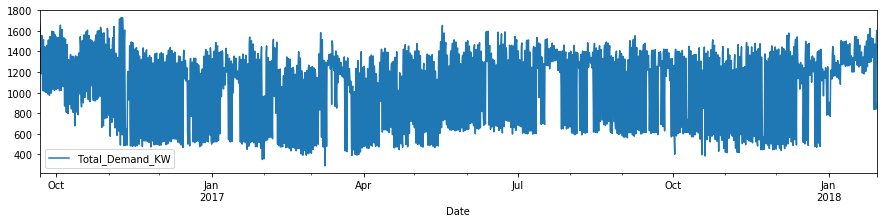

In [10]:
BPL_electric = pd.rolling_mean(dataBPL[['Total_Demand_KW']], 3).resample('6h').mean()
#BPL_electric = pd.rolling_mean(dataBPL[['Total_Demand_KW']], 3).resample('15min').mean()
#CH_electric = pd.rolling_mean(dataCH[['Total_Demand_KW']], 3).resample('D').mean()
BPL_electric.plot(figsize=(15,3))
#CH_electric.plot(figsize=(15,3),color='g')
#dataBPL[['Total_Demand_KW']].resample('H').rolling(window=3,center=False).mean().plot()
#dataCH[['Total_Demand_KW']].resample('H').rolling(window=3,center=False).mean().plot()

#### Compute the 1, 24, 168 autocorrelations for Boston Public Library Hourly_KW and autocorrelation plot.

In [11]:
print('Autocorrelation 1: ', BPL_electric['Total_Demand_KW'].autocorr(1))
print('Autocorrelation 7: ', BPL_electric['Total_Demand_KW'].autocorr(4))
print('Autocorrelation 168: ', BPL_electric['Total_Demand_KW'].autocorr(28))

('Autocorrelation 1: ', 0.16613735387344475)
('Autocorrelation 7: ', 0.85573951962332861)
('Autocorrelation 168: ', 0.84277398248429425)


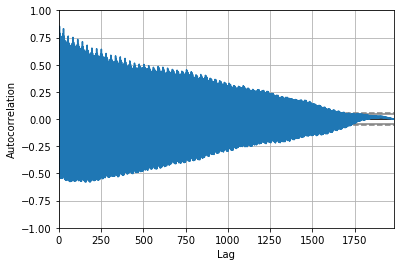

In [12]:
#from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(BPL_electric['Total_Demand_KW'])
#autocorrelation_plot(CH_electric['Total_Demand_KW'])

In [13]:
BPL_electric.tail(5)

,Total_Demand_KW
Date,
2018-01-28 12:00:00,1471.467593
2018-01-28 18:00:00,909.759259
2018-01-29 00:00:00,838.074074
2018-01-29 06:00:00,1491.671296
2018-01-29 12:00:00,1602.333333


/Users/ebola/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


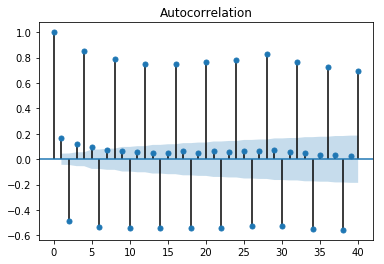

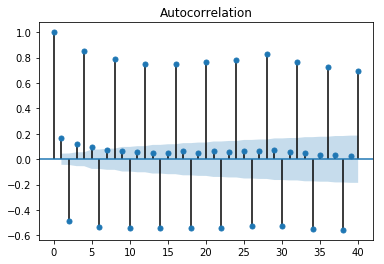

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

#plot_acf(dataBPL['Total_Demand_KW'], lags=10000)
plot_acf(BPL_electric['Total_Demand_KW'], lags=40)

# The dataBPL dataset is sampled every 5 minutes and show correlation peaks every 
# 7 day (2016 data points) cycles and subpeaks every 24 hours. The correlation 
# factor is 0.8 at 168 hours (weekly) 

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

In [15]:
BPL_electric.tail()

,Total_Demand_KW
Date,
2018-01-28 12:00:00,1471.467593
2018-01-28 18:00:00,909.759259
2018-01-29 00:00:00,838.074074
2018-01-29 06:00:00,1491.671296
2018-01-29 12:00:00,1602.333333


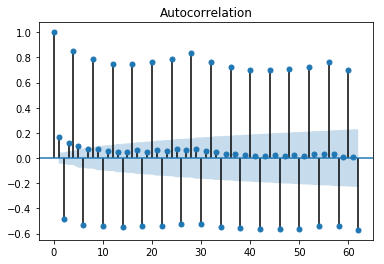

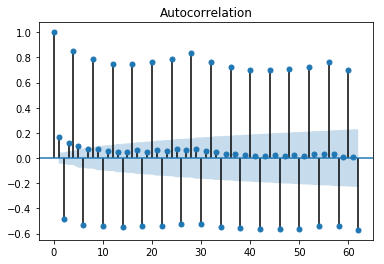

In [16]:

plot_acf(BPL_electric['Total_Demand_KW'], lags=62)

##### Split the energy consumption (5 min) data in a training and test set - using 75% of the data for training

In [17]:
#n = len(dataBPL.Total_Demand_KW)
n = len(BPL_electric.Total_Demand_KW)
#train = dataBPL.Total_Demand_KW[:int(.75*n)]
#test = dataBPL.Total_Demand_KW[int(.75*n):]
train = BPL_electric.Total_Demand_KW[:int(.75*n)]
test = BPL_electric.Total_Demand_KW[int(.75*n):]

In [18]:
test.head(5)

Date
2017-09-27 18:00:00    1366.212963
2017-09-28 00:00:00    1234.009259
2017-09-28 06:00:00    1360.263889
2017-09-28 12:00:00    1385.597222
2017-09-28 18:00:00    1281.055556
Freq: 6H, Name: Total_Demand_KW, dtype: float64

In [19]:
test.tail(5)

Date
2018-01-28 12:00:00    1471.467593
2018-01-28 18:00:00     909.759259
2018-01-29 00:00:00     838.074074
2018-01-29 06:00:00    1491.671296
2018-01-29 12:00:00    1602.333333
Freq: 6H, Name: Total_Demand_KW, dtype: float64

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [20]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [21]:
#model = sm.tsa.ARIMA(train, (1, 1, 0)).fit()
#print(model.params)

In [23]:
model = sm.tsa.ARIMA(train, (2, 1, 0)).fit()
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of differencing.
#q: The size of the moving average window, also called the order of moving average.
predictions = model.predict(
    '2017-09-27 20:00:00',
    '2018-01-29 14:00:00',
    dynamic=True
)
#predictions = model.predict(
#    '2016-12-31 17:10:00',
#    '2017-10-31 08:10:00',
#    dynamic=True, 
#)
print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 1101.2477975062397)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Total_Demand_KW   No. Observations:                 1485
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -10443.196
Method:                       css-mle   S.D. of innovations            273.929
Date:                Mon, 29 Jan 2018   AIC                          20894.393
Time:                        14:14:53   BIC                          20915.605
Sample:                    09-21-2016   HQIC                         20902.299
                         - 09-27-2017                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.1632      3.608     -0.045      0.964      -7.234       6.908
ar.L1.D.Total_Demand_KW    -0.1866      0.016    -11.629      0.000      -0.218      -0.155
ar.L2.D.Total_Demand_KW    -0.7849      0.016    -49.041      0.000      -0.816      -0.754
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1189           -1.1224j            1.1287           -0.2668
AR.2           -0.1189           +1.1224j            1.1287            0.2668
-----------------------------------------------------------------------------
"""

#### Plot the residuals - where are their significant errors.

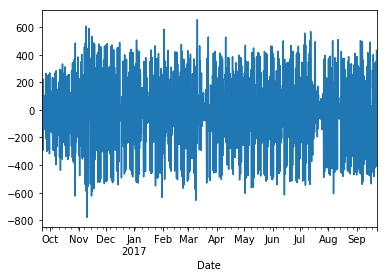

In [20]:
model.resid.plot()

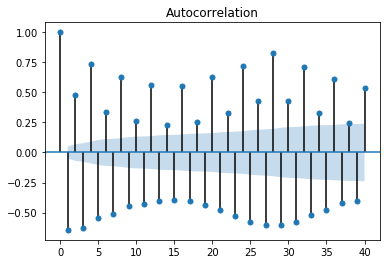

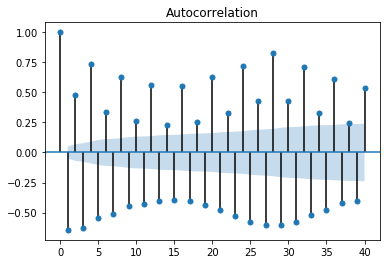

In [21]:
plot_acf(model.resid, lags=40)

#### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [24]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2017-09-27 20:00:00',
    '2018-01-29 14:00:00',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 294.84667258789176)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        Total_Demand_KW   No. Observations:                 1486
Model:                     ARMA(2, 0)   Log Likelihood              -10477.705
Method:                       css-mle   S.D. of innovations            279.148
Date:                Mon, 29 Jan 2018   AIC                          20963.409
Time:                        14:15:57   BIC                          20984.625
Sample:                    09-21-2016   HQIC                         20971.316
                         - 09-27-2017                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1081.6422      5.435    199.013      0.000    1070.990    1092.295
ar.L1.Total_Demand_KW     0.2293      0.021     10.677      0.000       0.187       0.271
ar.L2.Total_Demand_KW    -0.5623      0.021    -26.185      0.000      -0.604      -0.520
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2039           -1.3179j            1.3336           -0.2256
AR.2            0.2039           +1.3179j            1.3336            0.2256
-----------------------------------------------------------------------------
"""

In [93]:
model = sm.tsa.ARIMA(train, (2, 0, 1)).fit()

predictions = model.predict(
    '2017-09-27 20:00:00',
    '2018-01-29 14:00:00',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 294.63272067131589)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        Total_Demand_KW   No. Observations:                 1486
Model:                     ARMA(2, 1)   Log Likelihood              -10432.379
Method:                       css-mle   S.D. of innovations            270.750
Date:                Mon, 29 Jan 2018   AIC                          20874.758
Time:                        14:44:24   BIC                          20901.277
Sample:                    09-21-2016   HQIC                         20884.642
                         - 09-27-2017                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1081.7051      5.805    186.329      0.000    1070.327    1093.083
ar.L1.Total_Demand_KW     0.0928      0.026      3.625      0.000       0.043       0.143
ar.L2.Total_Demand_KW    -0.5672      0.022    -26.104      0.000      -0.610      -0.525
ma.L1.Total_Demand_KW     0.2182      0.022     10.146      0.000       0.176       0.260
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0818           -1.3253j            1.3278           -0.2402
AR.2            0.0818           +1.3253j            1.3278            0.2402
MA.1           -4.5829           +0.0000j            4.5829            0.5000
-----------------------------------------------------------------------------
"""

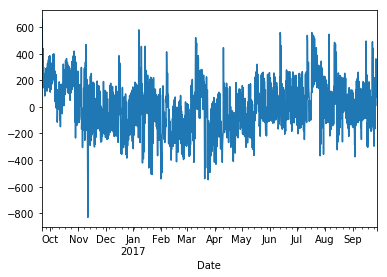

In [26]:
model.resid.plot()

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [104]:
model = sm.tsa.ARIMA(train, (2, 1, 2)).fit()

predictions = model.predict(
    '2017-09-27 20:00:00',
    '2018-01-29 14:00:00',
    dynamic=False, 
    typ='levels'
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 280.29380062057686)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Total_Demand_KW   No. Observations:                 1485
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9898.024
Method:                       css-mle   S.D. of innovations            189.620
Date:                Mon, 29 Jan 2018   AIC                          19808.048
Time:                        14:48:09   BIC                          19839.867
Sample:                    09-21-2016   HQIC                         19819.908
                         - 09-27-2017                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.1681      2.435     -0.069      0.945      -4.940       4.604
ar.L1.D.Total_Demand_KW     0.0142      0.009      1.551      0.121      -0.004       0.032
ar.L2.D.Total_Demand_KW    -0.9425      0.009    -99.259      0.000      -0.961      -0.924
ma.L1.D.Total_Demand_KW    -0.5961      0.029    -20.910      0.000      -0.652      -0.540
ma.L2.D.Total_Demand_KW     0.5499      0.021     26.422      0.000       0.509       0.591
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0075           -1.0300j            1.0300           -0.2488
AR.2            0.0075           +1.0300j            1.0300            0.2488
MA.1            0.5420           -1.2348j            1.3485           -0.1842
MA.2            0.5420           +1.2348j            1.3485            0.1842
-----------------------------------------------------------------------------
"""

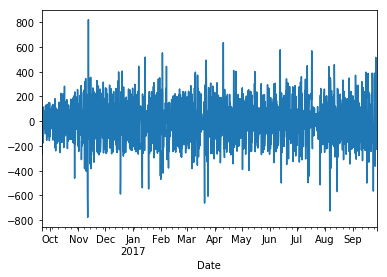

In [105]:
model.resid.plot()

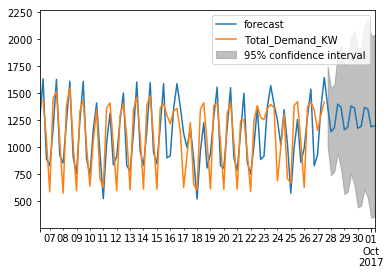

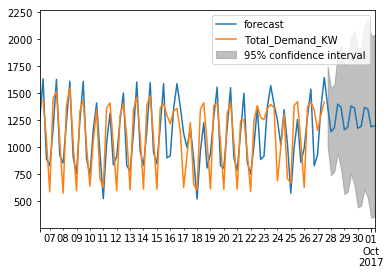

In [121]:
model.plot_predict(1400, 1500)

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt

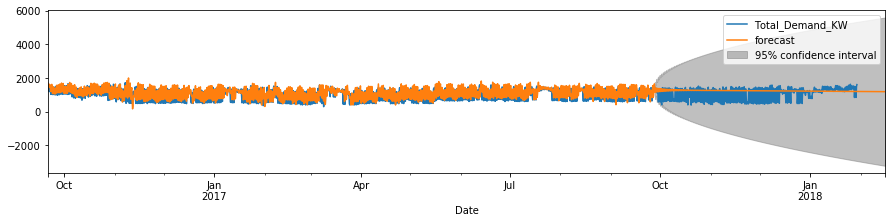

In [115]:
fig, ax = plt.subplots()
ax = BPL_electric.plot(ax=ax,figsize=(15,3))

fig = model.plot_predict(1, 2050, ax=ax, plot_insample=False)